In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import pandas as pd
from pyprojroot import here
import numpy as np
os.environ['KAGGLEHUB_CACHE'] = str(here("data"))
import kagglehub

path = kagglehub.dataset_download("datamunge/sign-language-mnist")
test_pd = pd.read_csv(os.path.join(path, "sign_mnist_test/sign_mnist_test.csv"))
train_pd = pd.read_csv(os.path.join(path, "sign_mnist_train/sign_mnist_train.csv"))
test_pd

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


In [4]:
os.environ['TORCH_HOME'] = str(here("cache"))
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from sklearn.model_selection import train_test_split
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class SignMNIST(Dataset):
  def __init__(self, df: pd.DataFrame):
    self.df = df
    self.target: np.array = self.df["label"].values
    self.data = self.df.drop(columns=["label"]).values
    self.data = self.data.reshape(self.data.shape[0], 28, 28)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: list[int]) -> tuple:
    image = self.data[index]  # shape (28, 28)

    image = image.astype(np.float32) / 255.0  # min max Normalize to [0, 1]
    image = torch.tensor(image) 
    image = image.unsqueeze(0) # Add channel dimension (C x H x W)
    image = torchvision.transforms.functional.resize(image, (244, 244))
    
    
    label = self.target[index]
    label = torch.tensor(label, dtype=torch.int64, device=DEVICE)

    return image, label

  @staticmethod
  def label_to_letter(label: int) -> str:
    return chr(label + 65)

  @property
  def shape(self) -> tuple:
    return self.data.shape, self.target.shape
  
keras.utils.set_random_seed(1)
train_pd_split, val_pd = train_test_split(train_pd, test_size=0.1, stratify=None)

train_dataloader = DataLoader(
  train := SignMNIST(train_pd_split),
  batch_size=32,
  shuffle=True,
  # num_workers=15
)
val_dataloader = DataLoader(
  val := SignMNIST(val_pd),
  batch_size=32,
  shuffle=False,
  # num_workers=15,
  # persistent_workers=True
)
test_dataloader = DataLoader(
  test := SignMNIST(test_pd),
  batch_size=32,
  shuffle=False,
  # num_workers=15,
)
train_dataloader

In [5]:
model = torchvision.models.squeezenet1_1(weights="DEFAULT")
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [6]:
from torchinfo import summary
from collections import namedtuple
Shape = namedtuple("Shape", ["batchsize", "channels", "height", "width"])	
summary(model, Shape(batchsize=64, channels=3, height=244, width=244), device=DEVICE)


Layer (type:depth-idx)                   Output Shape              Param #
SqueezeNet                               [64, 1000]                --
├─Sequential: 1-1                        [64, 512, 15, 15]         --
│    └─Conv2d: 2-1                       [64, 64, 121, 121]        1,792
│    └─ReLU: 2-2                         [64, 64, 121, 121]        --
│    └─MaxPool2d: 2-3                    [64, 64, 60, 60]          --
│    └─Fire: 2-4                         [64, 128, 60, 60]         --
│    │    └─Conv2d: 3-1                  [64, 16, 60, 60]          1,040
│    │    └─ReLU: 3-2                    [64, 16, 60, 60]          --
│    │    └─Conv2d: 3-3                  [64, 64, 60, 60]          1,088
│    │    └─ReLU: 3-4                    [64, 64, 60, 60]          --
│    │    └─Conv2d: 3-5                  [64, 64, 60, 60]          9,280
│    │    └─ReLU: 3-6                    [64, 64, 60, 60]          --
│    └─Fire: 2-5                         [64, 128, 60, 60]         --
│  

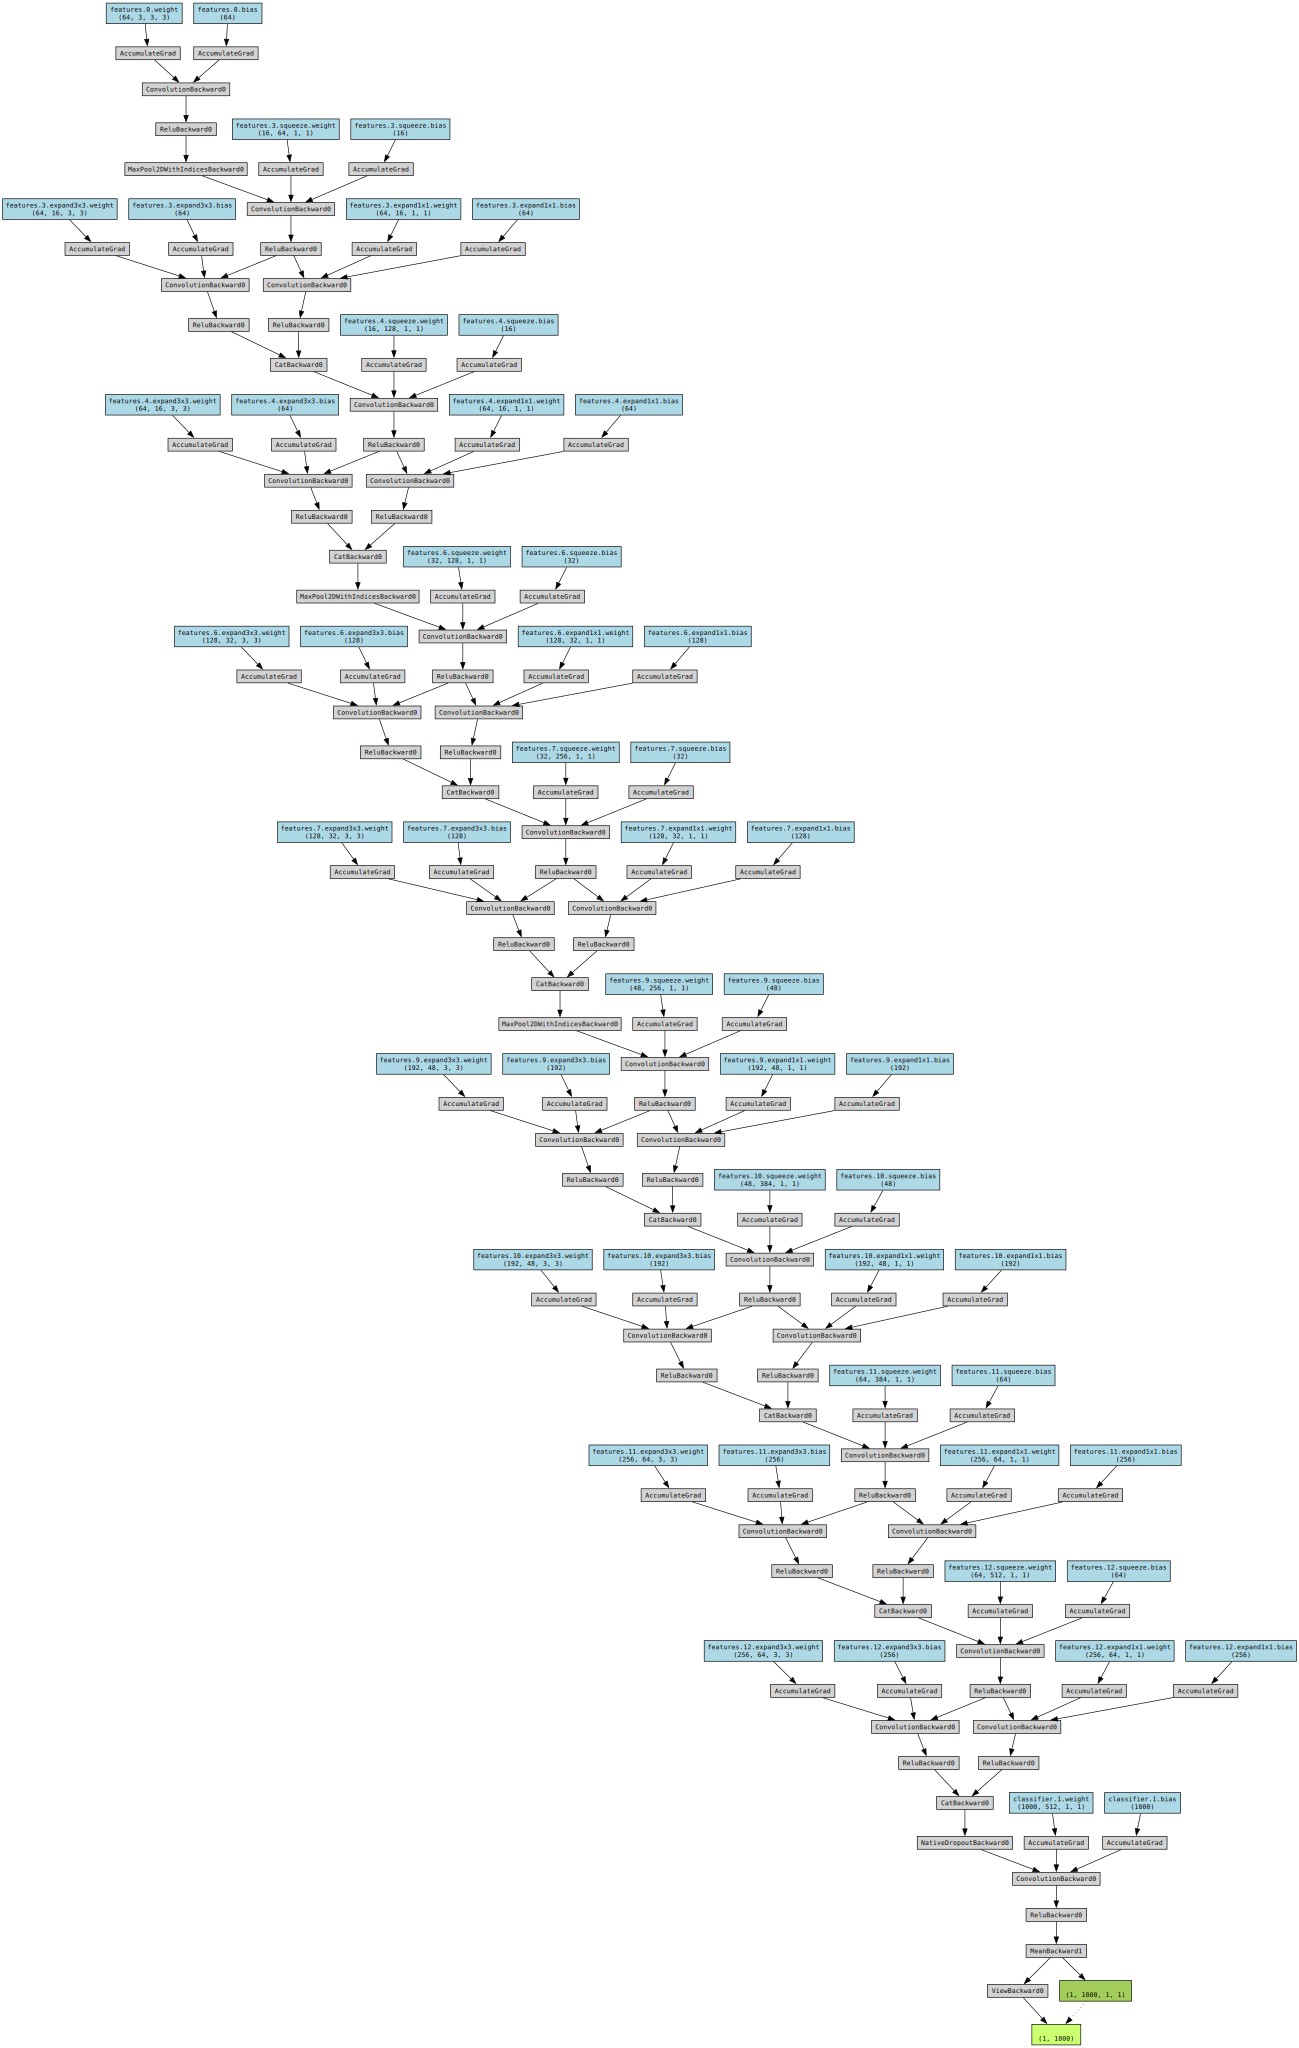

In [7]:
import torchviz

torchviz.make_dot(
  model(torch.randn(1, 3, 256, 256).to(DEVICE)),
  params=dict(model.named_parameters())
)

In [6]:
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [20]:
import lightning as L
import torchvision.transforms as transforms
from collections import namedtuple

Metrics = namedtuple("Metrics", ["loss", "accuracy"])

class ReconstructSquezeNet(L.LightningModule):
  def __init__(self):
    super().__init__()
    self.the_model = torchvision.models.squeezenet1_1(weights="DEFAULT")
    self.results: list[Metrics] = []
    self._results_epoch: list[Metrics] = []
    with torch.no_grad():
      # change out to 26 classes
      self.the_model.classifier[1] = torch.nn.Conv2d(512, 26, kernel_size=(1, 1), stride=(1, 1)) # 26 letters of the alphabet
      
      # change in to 1 channel and keep weights somewhat similar
      trained_inp_layer = self.the_model.features[0]
      new_inp_layer = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
      new_inp_layer.weight.data = trained_inp_layer.weight.data.mean(dim=1, keepdim=True)
      new_inp_layer.bias.data = trained_inp_layer.bias.data
      self.the_model.features[0] = new_inp_layer
      

      # reconstruct classifier layers / reset weights
      def recursive_reset(m):
        if hasattr(m, "reset_parameters"):
          m.reset_parameters()
        for child in m.children():
          recursive_reset(child)
      recursive_reset(self.the_model.classifier)
          
  def training_step(self, batch, batch_idx):
    x, _ = batch
    y = self.the_model(x)
    loss = torch.nn.functional.cross_entropy(y, _)
    return loss
  
  def validation_step(self, batch, batch_idx):
    x, _ = batch
    y = self.the_model(x)
    loss = torch.nn.functional.cross_entropy(y, _)
    self.log("val_loss", loss, prog_bar=True)
    acc = (y.argmax(dim=1) == _).float().mean()
    self.log("val_acc", acc, prog_bar=True)
    self._results_epoch.append(Metrics(loss.item(), acc.item()))
    
  def on_validation_epoch_start(self):
    self._results_epoch = []
  def on_validation_epoch_end(self):
    self.results.append(Metrics(
      np.mean([m.loss for m in self._results_epoch]),
      np.mean([m.accuracy for m in self._results_epoch])
    ))
    self._results_epoch = []
  def test_step(self, batch, batch_idx):
    x, _ = batch
    y = self.the_model(x)
    loss = torch.nn.functional.cross_entropy(y, _)
    self.log("test_loss", loss, prog_bar=True)
    acc = (y.argmax(dim=1) == _).float().mean()
    self.log("test_acc", acc, prog_bar=True)
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)
    
reconstruct_squezenet = ReconstructSquezeNet()
reconstruct_squezenet

ReconstructSquezeNet(
  (the_model): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [21]:
list(model.features[3].children())

[Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1)),
 ReLU(inplace=True),
 Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1)),
 ReLU(inplace=True),
 Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True)]

In [22]:
torch.set_float32_matmul_precision('high')
keras.utils.set_random_seed(1)
trainer = L.Trainer(
  max_epochs=10,
  default_root_dir=str(here("cache")),
  enable_checkpointing=False,
)
out = trainer.fit(
  model=reconstruct_squezenet, 
  train_dataloaders=train_dataloader, 
  val_dataloaders=val_dataloader
)
out

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | the_model | SqueezeNet | 734 K  | train
-------------------------------------------------
734 K     Trainable params
0         Non-trainable params
734 K     Total params
2.939     Total estimated

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [23]:
out_test = trainer.test(model=reconstruct_squezenet, dataloaders=test_dataloader)
out_test

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9760178327560425     │
│         test_loss         │    0.08300475031137466    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08300475031137466, 'test_acc': 0.9760178327560425}]

In [24]:
reconstruct_squezenet.results

[Metrics(loss=np.float64(3.4205881357192993), accuracy=np.float64(0.046875)),
 Metrics(loss=np.float64(3.2509394357370778), accuracy=np.float64(0.040697674418604654)),
 Metrics(loss=np.float64(3.1957915078761965), accuracy=np.float64(0.04259838999877142)),
 Metrics(loss=np.float64(3.0781165804973867), accuracy=np.float64(0.08256932023132957)),
 Metrics(loss=np.float64(0.6078779337018035), accuracy=np.float64(0.7832625231077505)),
 Metrics(loss=np.float64(0.09935639027051281), accuracy=np.float64(0.9712097499259683)),
 Metrics(loss=np.float64(0.16760064153607154), accuracy=np.float64(0.944599732410076)),
 Metrics(loss=np.float64(0.01352097920438567), accuracy=np.float64(0.997093023255814)),
 Metrics(loss=np.float64(0.00725579063179984), accuracy=np.float64(0.998546511627907)),
 Metrics(loss=np.float64(0.07578983836284288), accuracy=np.float64(0.9802940522515496)),
 Metrics(loss=np.float64(0.00715370222247276), accuracy=np.float64(0.9981831395348837))]

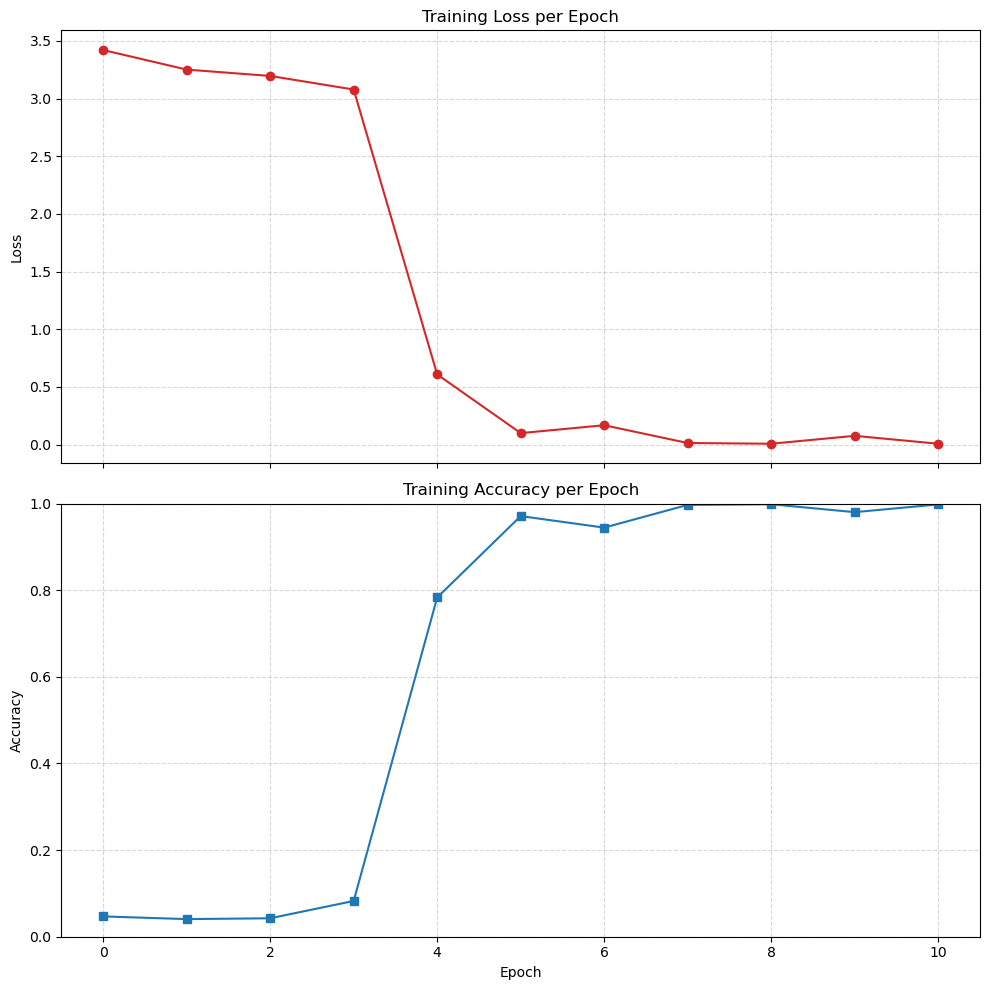

In [25]:
metrics = pd.DataFrame(
  [(i, m.loss, m.accuracy) for i, m in enumerate(reconstruct_squezenet.results)],
  columns=["epoch", "loss", "accuracy"]
).set_index("epoch")
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot Loss
axes[0].plot(metrics.index, metrics["loss"], marker='o', color='tab:red')
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss per Epoch")
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot Accuracy
axes[1].plot(metrics.index, metrics["accuracy"], marker='s', color='tab:blue')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training Accuracy per Epoch")
axes[1].set_ylim(0, 1)  # Show accuracy between 0 and 1
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [26]:
# save model
torch.save(reconstruct_squezenet.state_dict(), str(here("models/reconstructed_squezenet.pth")))

The frozen model achieved an imediate good result, with the performance increasing steadily, while the reset model needed some epochs to achieve a similar performance